In [41]:
%matplotlib inline
import numpy as np
import pandas as pd

from scipy import misc
import matplotlib.pyplot as plt

In [25]:
IMAGE_PATH = 'data/images/capture/'

In [22]:
data_1 = pd.DataFrame.from_csv('data/labels/rugby_image_labels.csv')
data_2 = pd.DataFrame.from_csv('data/labels/rugby_image_labels_2.csv')

In [23]:
data_1.head()

,y
filne_name,
1489359202.14.jpg,154.0
1489359202.84.jpg,142.0
1489359203.37.jpg,159.0
1489359204.0.jpg,156.0
1489359204.63.jpg,161.0


In [38]:
test_img = misc.imread(IMAGE_PATH + data_2.iloc[0].name)

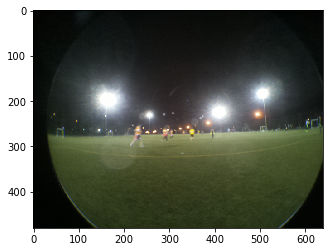

In [43]:
plt.imshow(test_img)
plt.show()